In [1]:
%load_ext Cython
%pylab inline
import numpy as np
import random
import pandas as pd
import os

# Нужно для кириллицы при построении графиков
rcParams['font.family'] = 'Arial'
import sys  
reload(sys)  
sys.setdefaultencoding('utf8')

The Cython magic has been move to the Cython package, hence 
`%load_ext cythonmagic` is deprecated; Please use `%load_ext Cython` instead.

Though, because I am nice, I'll still try to load it for you this time.
Populating the interactive namespace from numpy and matplotlib

In [3]:
%%cython
# Описываются распределения рассмотренные в работе
import numpy as np
cimport numpy as np
cimport cython
from libc.math cimport exp, sqrt

cdef int n = 1000
xs = np.linspace(0, 1, n)

@cython.boundscheck(False)
def integrate(fs):
    cdef:
        int i
        double res = 0
    for i in xrange(n):
        res += fs[i]
    return res / n

#Пара гауссовых распределений
def _pdf_ga1(double x):
    #return exp(-((x - 0.4525)**2) / 0.02) #DEL
    return exp(-((x - 0.475)**2) / 0.02)

def _pdf_ga2(double x):
    #return exp(-((x - 0.5475)**2) / 0.02) #DEL
    return exp(-((x - 0.525)**2) / 0.02)

#Пара бимодальных распределений

cdef double fun(double x):
    return x * x * exp(-24 * x)

cdef double fun_orlov(double x):
    return 1 - abs(x) * 4

cdef double h(double x):
    if x < 0:
        return 0
    return 1

cdef __pdf(double x, double alpha):
    return h(0.5 - x) * fun_orlov(0.25 - x) * (1 - alpha) +  alpha * h(x - 0.5) * fun_orlov(x - 0.75)

def _pdf_bi1(double x):
    return __pdf(x, 0.4)

def _pdf_bi2(double x):
    return __pdf(x, 0.6)

# Пара распределение с разными дисперсиями
def _pdf_di1(double x):
    return 1

def _pdf_di2(double x):
    return (x - 0.5) ** 8 + 0.5**8 / 5.0

def _pdf_di3(double x):
    #return 0.1 + (x - 0.5) ** 4
    return 1 / sqrt((x + 0.002) * (1 - x + 0.002))

pdf_ga1 = np.vectorize(_pdf_ga1)
pdf_ga2 = np.vectorize(_pdf_ga2)
pdf_bi1 = np.vectorize(_pdf_bi1)
pdf_bi2 = np.vectorize(_pdf_bi2)
pdf_di1 = np.vectorize(_pdf_di1)
pdf_di2 = np.vectorize(_pdf_di2)
#pdf_di3 = np.vectorize(_pdf_di3)

pdfs = [pdf_ga1, pdf_ga2, pdf_bi1, pdf_bi2, pdf_di1, pdf_di2] #, pdf_di3]
pdfs = [x(xs) / integrate(x(xs)) for x in pdfs]

cdfs = [np.cumsum(_pdf) / n for _pdf in pdfs]
means = [np.sum(xs * _pdf) / n for _pdf in pdfs]

#integrate(pdf(x=xs, alpha=1 / 10.0))
#pdfs =  [pdf(x=xs, alpha=i / 10.0) / integrate(pdf(x=xs, alpha=i / 10.0)) for i in range(0,11)]

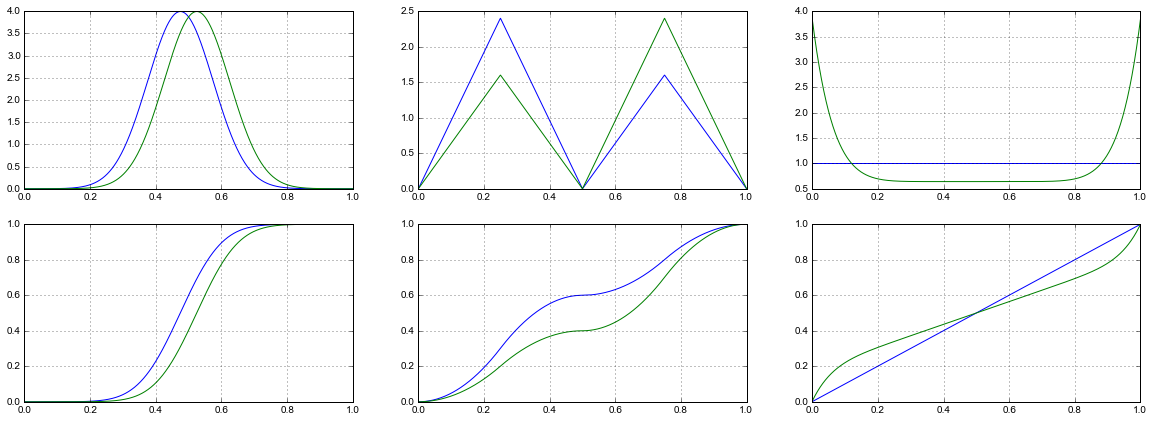

In [5]:
# Построенние графиков распределений (всем вместе)
fig, axes = subplots(nrows=2, ncols=3, figsize=(20, 7))
for i in xrange(3):
    #axes[0, i].set_ylim([0,4])
    axes[1, i].set_ylim([0,1])
    axes[0, i].plot(xs, pdfs[2*i])
    axes[0, i].plot(xs, pdfs[2*i + 1])
    axes[1, i].plot(xs, cdfs[2*i])
    axes[1, i].plot(xs, cdfs[2*i + 1])
    axes[0, i].grid(True)
    axes[1, i].grid(True)
savefig("/Users/alex/Documents/NIR/pdfs.png", dpi=300)

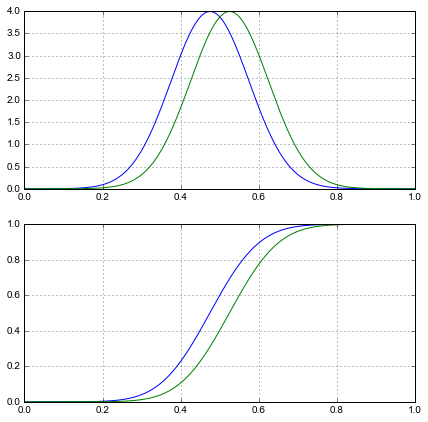

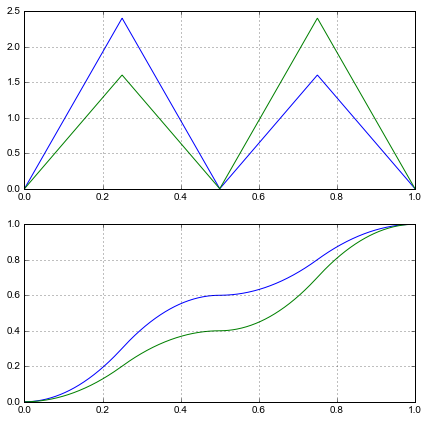

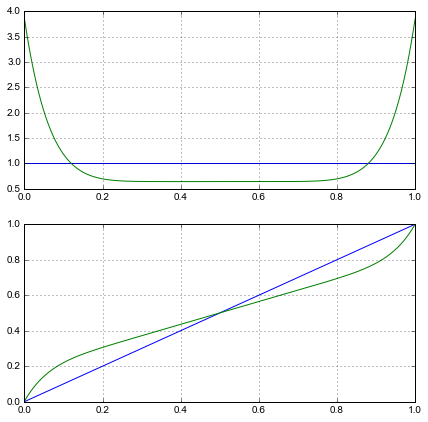

In [6]:
# Построенние графиков распределений (по отдельности)
for i in xrange(3):
    fig, axes = subplots(nrows=2, ncols=1, figsize=(7, 7))
    axes[1].set_ylim([0,1])
    axes[0].plot(xs, pdfs[2*i])
    axes[0].plot(xs, pdfs[2*i + 1])
    axes[1].plot(xs, cdfs[2*i])
    axes[1].plot(xs, cdfs[2*i + 1])
    axes[0].grid(True)
    axes[1].grid(True)
    savefig("/Users/alex/Documents/NIR/pdfs_%s.png" % i, dpi=300)

In [201]:
%%cython
# Создаем генератор случайных чисел с заданным распределением
import numpy as np
cimport numpy as np
cimport cython

@cython.boundscheck(False)
#@cython.wraparound(False)
def inverse(double x, np.ndarray cdf, int n):
    cdef:
        int left = 0
        int right = n - 1
        int mean

    while right - left > 1:
       mean = (left + right)/ 2
       if cdf[mean] > x:
          right = mean
       else:
          left = mean
    return float(mean) / n
    
    
inverse_vect = np.vectorize(inverse, excluded=['cdf', 'n'], otypes=[np.float])
def rand(np.ndarray cdf, int N):
    rands = np.random.rand(N)
    return np.sort(inverse_vect(x=rands, cdf=cdf, n=len(cdf)))

In [8]:
%%cython
#Восстановление функции распределения
import numpy as np
cimport numpy as np
cimport cython

cdef int n = 1000
xs = np.linspace(0,1,n)

#Квартическое ядро
cdef double Q(double x, double x0, double h):
    cdef:
        double d = (x - x0) / h       
    if d > 1 or d < - 1:
        return 0.0
    
    return 15/16.0 * (1 - d * d) * (1 - d * d)

#Квартическое ядро
def _Q(double x, double x0, double h):
    cdef:
        double d = (x - x0) / h       
    if d > 1 or d < - 1:
        return 0.0
    
    return 15/16.0 * (1 - d * d) * (1 - d * d)


Q_vec = np.vectorize(_Q, excluded=['h', 'x0'])

# Частичные интегралы
Q_part_int = np.zeros(n)
s = 0
for i in xrange(n):
    s += 2 * Q(i / float(n), 0.5, 0.5) / float(n)
    Q_part_int[i] = s


# Восстановленная PDF (series должен быть отсортирован)
def restore_pdf(s, double h):
    cdef:
        int left = 0
        int right = 0
        int l = len(s) - 1
        int i = 0
        int k
        double koef
    res = np.zeros(len(xs))
    for x in xs:
        while s[left] < x - h and left < l:
            left += 1
        while s[right] < x + h and right < l:
            right += 1
            
        # Для крайних точек нужно правильно учесть интеграл с ядром
        if x < h:
            koef = Q_part_int[<int>((1 + x / h) * n / 2.0)]
        elif x > 1 - h:
            koef = Q_part_int[<int>((1 + (1 - x) / h) * n / 2.0)]
        else:
            koef = 1

        for k in xrange(left, right):
            res[i] += Q(s[k], x, h) / koef
        i += 1
    return res / ((l + 1) * h)


# Восстановленная CDF
def restore_cdf(s):
    cdef:
        int left = 0
        double l = len(s)
        int i = 0
    res = np.zeros(len(xs))
    for x in xs:
        while s[left] < x and left < l - 1:
            left += 1
            
        res[i] = left / l
        i += 1
    return res

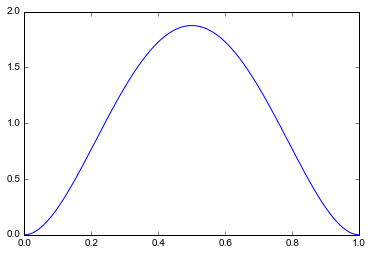

In [9]:
# Иллюстрация квартического ядра
plot(xs, 2 * Q_vec(xs, 0.5, 0.5))
#title(u"Квартическое ядро" , size=15)
savefig("/Users/alex/Documents/NIR/core.png", dpi=300)

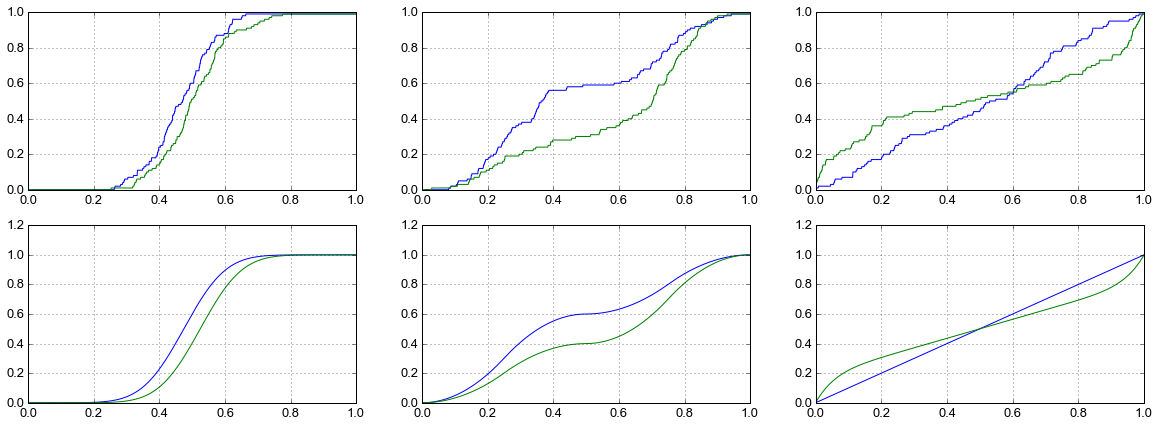

In [40]:
# Строим восстановленные графики, для примера N=100
N = 100
IS_CDF = 1  # 1 - графики CDF иначе - PDF
mpl.rcParams['xtick.labelsize'] = 13
mpl.rcParams['ytick.labelsize'] = 13
fig, axes = subplots(nrows=2, ncols=3, figsize=(20, 7))
for i in xrange(3):
    for j in xrange(2):
        l = rand(cdfs[2*i + j], N)
        h = 2 * np.std(l) / np.power(N, 0.2) 
        print i, h
        #axes[0, i].plot(xs, restore_pdf(l, h))
        if IS_CDF:
            axes[0, i].plot(xs, restore_cdf(l))
            axes[1, i].plot(xs, cdfs[2*i + j])
        else:
            axes[0, i].plot(xs, restore_pdf(l, h))
            axes[1, i].plot(xs, pdfs[2*i + j])           
        axes[0, i].grid(True)
        axes[1, i].grid(True)
#title(u"Пример восстановленных ФР и ПФР. Длина выборки %s" % N)
savefig("/Users/alex/Documents/NIR/%s_restored_N=%s.png" % ("cdfs" if IS_CDF else "pdfs", N), dpi=300)

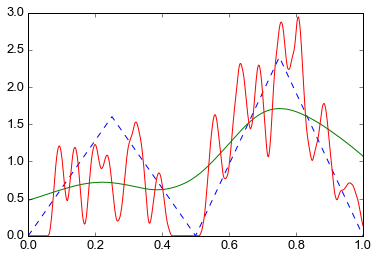

In [59]:
# Иллюстрация к выбору окна h
l = rand(cdfs[3], N)
plot(xs, pdfs[3], "--")
plot(xs, restore_pdf(l, h=0.3))
plot(xs, restore_pdf(l, h=0.03))
savefig("/Users/alex/Documents/NIR/h_choice.png", dpi=300)

In [10]:
%%cython
#Описываются различные метрики
import numpy as np
cimport numpy as np

#Расстояние в норме L1
def distL1(np.ndarray fun1, np.ndarray fun2):
    return np.sum(np.abs(fun1 - fun2)) / 1000.0

#Расстояние в норме C
def distC(np.ndarray fun1, np.ndarray fun2):
    return np.max(np.abs(fun1 - fun2))

# Расстояние Кульбака-Лейблера, h - ширина окна при восстановление PDF
def distKL(np.ndarray fun1, np.ndarray fun2, double h): 
    return np.sum(np.log((fun1 + h) / (fun2 + h)) * fun1) / 1000.0

# Расстояние в норме http://en.wikipedia.org/wiki/Hellinger_distance
def distHE(np.ndarray fun1, np.ndarray fun2):
    return 2 - 2 * np.sum(np.sqrt(fun1 * fun2)) / 1000.0

# Плохие:
# Łukaszyk–Karmowski metric
# Jensen–Shannon divergence (симметричный KL)

# Считаем все расстояния сразу
def all_distances(line1, line2):
    pdf, cdf, mean, h = line1[["pdf", "cdf", "mean", "h"]]
    _pdf, _cdf, _mean, _h = line2[["pdf", "cdf", "mean", "h"]]
    h = (h + _h) / 2.0
    res = { "mean": abs(mean - _mean),
            "KL": distKL(pdf, _pdf, h),
            "L1_pdf": distL1(pdf, _pdf),
            "L1_cdf": distL1(cdf, _cdf),
            "C_pdf": distC(pdf, _pdf),
            "C_cdf": distC(cdf, _cdf),
            "HE": distHE(pdf, _pdf)}
    
    return res

In [11]:
# Считаем расстояния между эталоннами в различных нормах
def all_distance_native(num1, num2):
    mean, pdf, cdf = np.mean(xs * pdfs[num1]), pdfs[num1], cdfs[num1]
    _mean, _pdf, _cdf = np.mean(xs * pdfs[num2]), pdfs[num2], cdfs[num2]
    res = { "mean": abs(mean - _mean),
            "KL": distKL(pdf, _pdf, 0.000001),
            "L1_pdf": distL1(pdf, _pdf),
            "L1_cdf": distL1(cdf, _cdf) ,
            "C_pdf": distC(pdf, _pdf),
            "C_cdf": distC(cdf, _cdf),
            "HE": distHE(pdf, _pdf)}
    for k in res:
        res[k] = round(res[k], 3)
    return res
    


df = pd.DataFrame.from_dict(all_distance_native(0, 1), 'index') 
df = df.sort_index()
df["Уномодальные"] = pd.DataFrame.from_dict(all_distance_native(0, 1), 'index')
df["Бимодальные"] = pd.DataFrame.from_dict(all_distance_native(2, 3), 'index')
df["Разные дисперсии"] = pd.DataFrame.from_dict(all_distance_native(4, 5), 'index')
df.ix[:,1:]

,Уномодальные,Бимодальные,Разные дисперсии
C_cdf,0.197,0.200,0.121
C_pdf,1.186,0.800,2.846
HE,0.062,0.040,0.080
KL,0.125,0.081,0.148
L1_cdf,0.050,0.100,0.072
L1_pdf,0.395,0.400,0.485
mean,0.050,0.100,0.000


In [12]:
# Генерируем по n_base выборок длинной N из каждого распределения и восстанавливаем ПФР и ФР
def generateBaseNew(N, n_base = 500):
    global base
    # Создаем базу распределений для последующей попарной выборки
    base = pd.DataFrame(index=range(n_base * len(cdfs)), columns=["type", "pdf", "cdf", "mean", "h"])
    nLine = 0
    for j, cdf in enumerate(cdfs):
        for i in xrange(n_base):
            s = rand(cdf, N)
            h = 2 / np.power(N, 0.2) * np.std(s)
            #Восстанавливаем PDF и CDF
            base.type[nLine] = j
            base.pdf[nLine] = restore_pdf(s, h)
            base.cdf[nLine] = restore_cdf(s)
            base["mean"][nLine] = np.mean(s)
            base.h[nLine] = h
            nLine += 1

In [13]:
methods = ["mean", "KL", "L1_pdf", "L1_cdf", "C_pdf", "C_cdf", "HE"]
convert_methods_names = {
    "mean" : u"Разница средних",
    "KL": u"Норма $KL$",
    "L1_pdf": u"Норма $L_1$ для ПФР",
    "L1_cdf": u"Норма $L_1$ для ФР",
    "HE": u"Норма $HE$",
    "C_pdf": u"Норма $C$ для ПФР",
    "C_cdf": u"Норма $C$ для ФР"
}

# Группируем расстояния для одиннаковых распределений и для разных. !base должен быть уже посчитан!
def calc_dists_for_pair(ind1, ind2, n_experiments):
    distrbs = [base[base.type == ind1], base[base.type == ind2]]
    # в 1ый индекс будем складывать расстояния между одиннаковыми, в 0ый - между разными распределениями
    dists = {x : [[], []] for x in methods}
    
    for i in xrange(n_experiments):
        choose1, choose2 = randint(2), randint(2)
        line1, line2 = random.choice(distrbs[choose1].index), random.choice(distrbs[choose2].index)
        line1, line2 = base.ix[line1], base.ix[line2]
        r = all_distances(line1, line2)
        for method in methods:
            dists[method][choose1 == choose2] += [r[method]]
    
    for method in methods:
        dists[method][0] = np.sort(dists[method][0])
        dists[method][1] = np.sort(dists[method][1])

    return dists

In [43]:
# Считаем ошибку метода, если порог = thresh
def calc_error(thresh, array):
    error_diff = np.searchsorted(array[0], thresh)
    error_same = len(array[1]) - np.searchsorted(array[1], thresh) - 1
    return (error_diff + error_same) / float(len(array[0]) + len(array[1]))

# Подбираем порог так, чтобы ошибка была минимальна
# is_plot=True - строим график зависимости ошибки от порога
def analyze_for_method(dists, method_name, is_plot=True, axe=None):
    g = dists[method_name]
    _min = min(min(g[0]), min(g[1]))
    _max = max(max(g[0]), max(g[1]))
    steps = np.linspace(_min, _max, 1000)
    ys = np.asarray([calc_error(x, g) for x in steps])
    if is_plot:
        if axe is None:
            plot(linspace(0,1,1000), ys, label=convert_methods_names[method_name])
        else:
            axe.plot(linspace(0,1,1000), ys, label=convert_methods_names[method_name])
    
    return min(ys)

In [44]:
pairs_dict = {
    (0, 1): u"Пара гаусс-подобных распределений. Длина выборки %s",
    (2, 3): u"Пара бимодальных распределений. Длина выборки %s",
    (4, 5): u"Пара распределений с различными дисперсиями. Длина выборки %s" }

pair_to_short = {(0, 1): "gaus", (2, 3): "bim", (4, 5): "disp"}

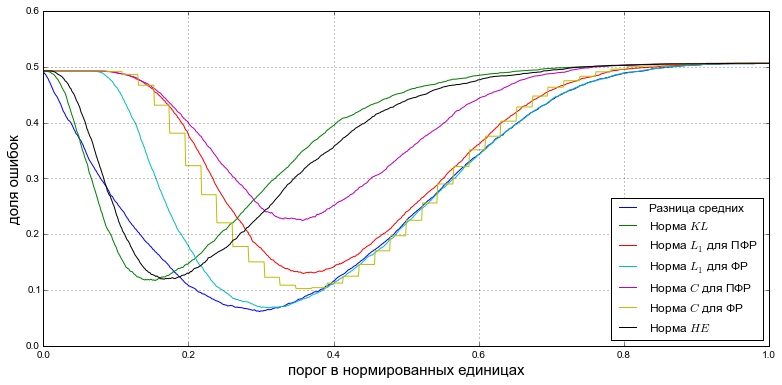

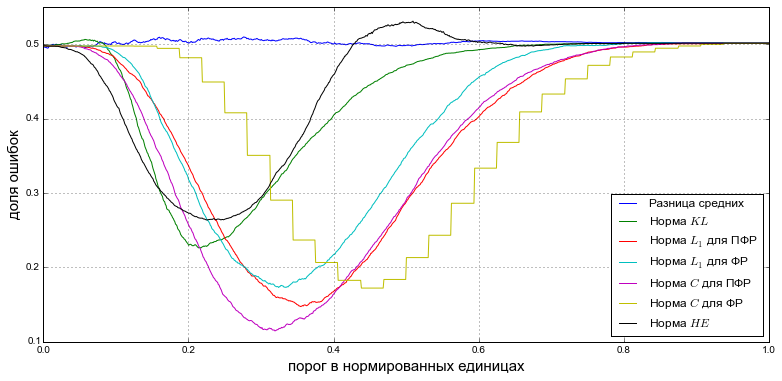

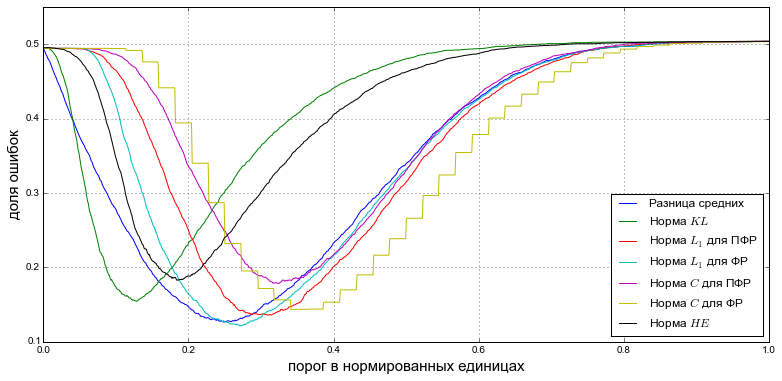

In [56]:
# Для каждой пары строим зависимость доли ошибки от порога в нормированных единицах
Ns = [10, 25, 50, 100, 250]
Ns = [100]
for i, N in enumerate(Ns):
    generateBaseNew(N) # Длина выборки = N
    for key in pairs_dict:
        figure(figsize=(13,6))
        ind1, ind2 = key
        text = pairs_dict[key]
        
        # Расматриваем 5000 экспериментов
        # Анализируем пару (ind1, ind2) - первые два распределения.
        r = calc_dists_for_pair(ind1, ind2, 5000) 

        for k in xrange(7):
            analyze_for_method(r, methods[k])

        #title(text % N, fontsize=18)
        ylabel(u'доля ошибок', fontsize=15)
        xlabel(u'порог в нормированных единицах', fontsize=15)
        legend(loc=4)
        grid(True)
        savefig("/Users/alex/Documents/NIR/graph_%s_N=%s.png" % (pair_to_short[(ind1, ind2)], N), dpi=300)

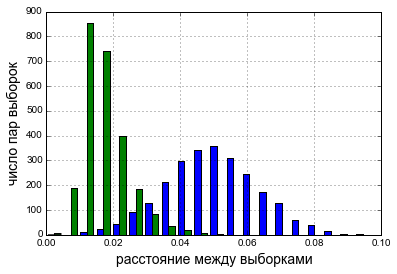

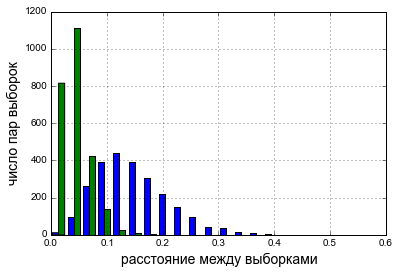

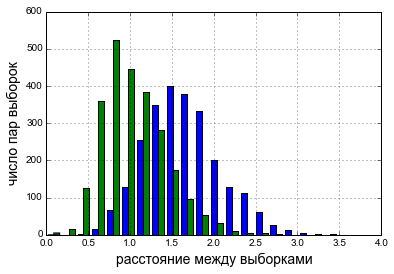

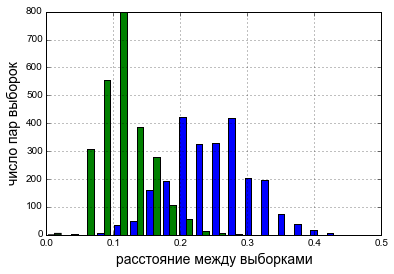

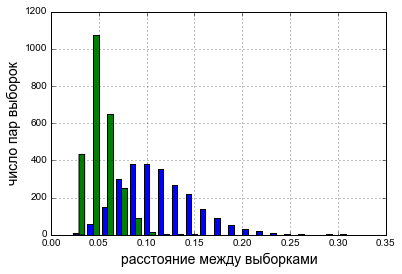

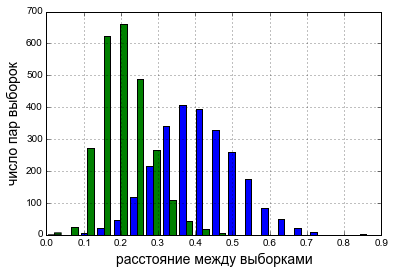

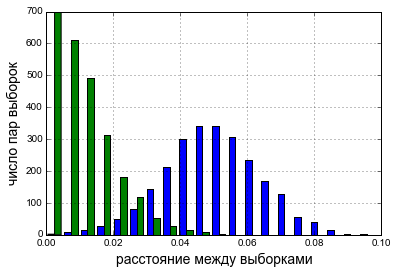

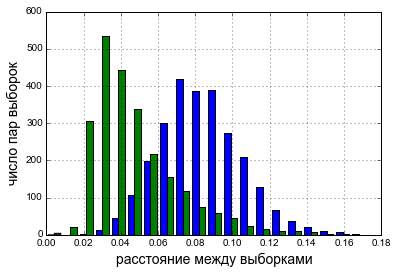

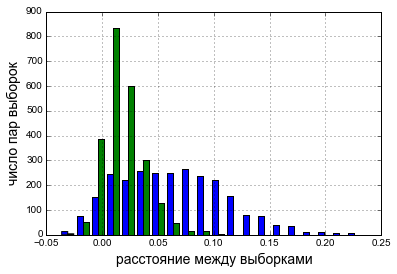

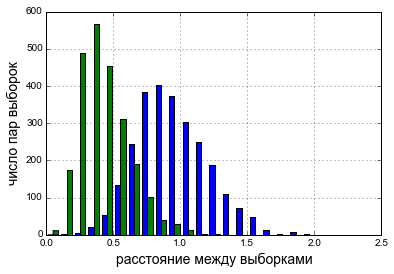

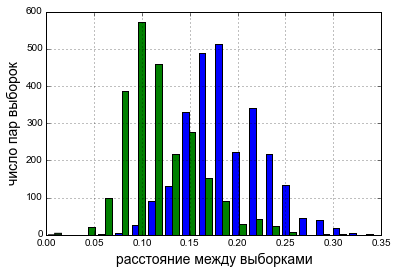

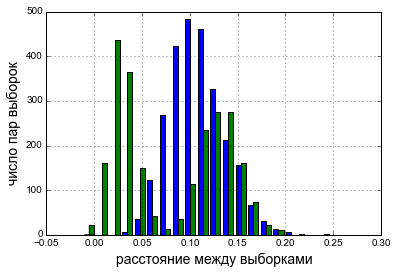

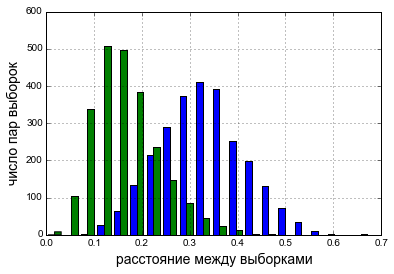

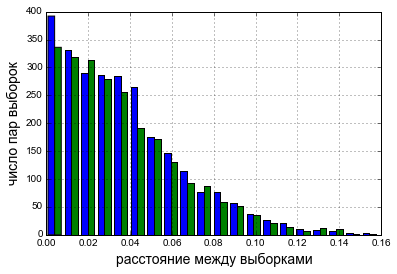

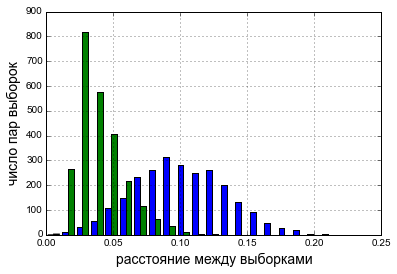

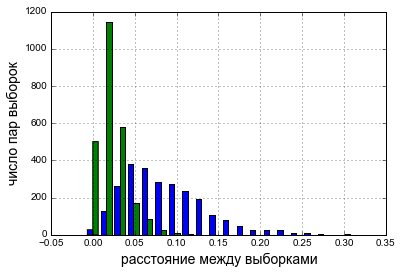

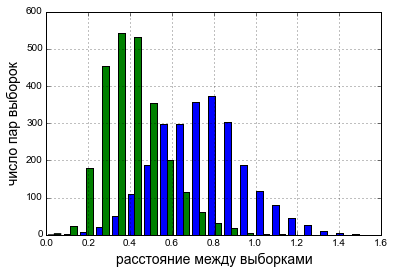

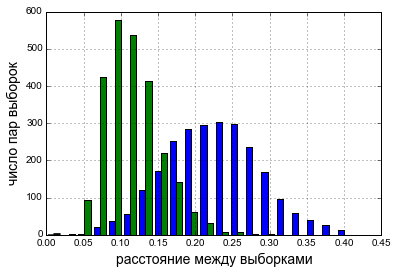

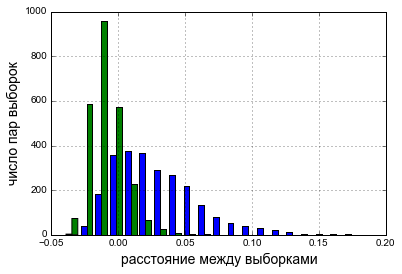

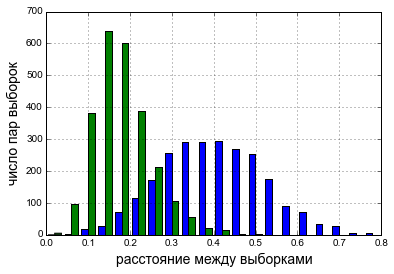

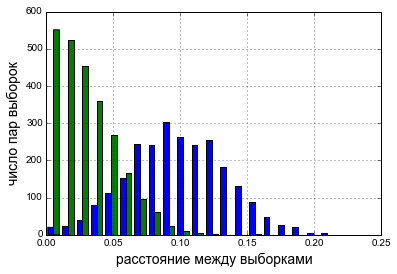

In [34]:
# Гистограммы - свой-чужой

Ns_hist = [100]

for N in Ns_hist:
    generateBaseNew(N)
    for pair in pairs_dict:
        ind1, ind2 = pair
        r = calc_dists_for_pair(ind1, ind2, 5000) 
        for method in r:
            figure()
            #title(pairs_dict[pair] % N + ". " + convert_methods_names[method], fontsize=14)
            hist(r[method], bins=20) 
            ylabel(u'число пар выборок', fontsize=14)
            xlabel(u'расстояние между выборками', fontsize=14)
            grid(True)
            #legend(loc=4)
            savefig("/Users/alex/Documents/NIR/hist_%s_N=%s_method=%s.png" % (pair_to_short[(ind1, ind2)], N, method), 
                    dpi=300)

In [48]:
# Для каждого распределения получаем максимальную точность в зависимости от N
pairs = ((0, 1),(2, 3), (4, 5))
global_results = {pair: {} for pair in pairs}
Ns = [10,  20,  40,  60,  80, 100,
          120, 140, 160, 180, 200,
          220, 240, 260, 280, 300]
#Ns = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

for N in Ns:
    generateBaseNew(N)
    print N
    for pair in pairs:
        r = calc_dists_for_pair(pair[0], pair[1], 5000) 
        results_for_methods = {method: analyze_for_method(r, method, is_plot=False) for method in methods}
        global_results[pair][N] = results_for_methods

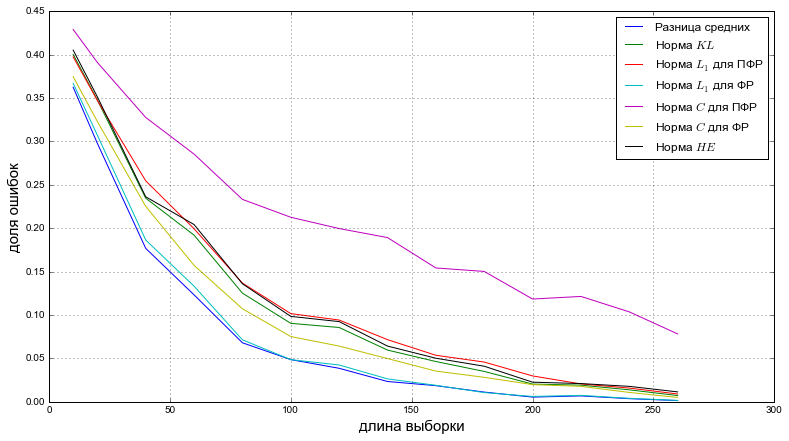

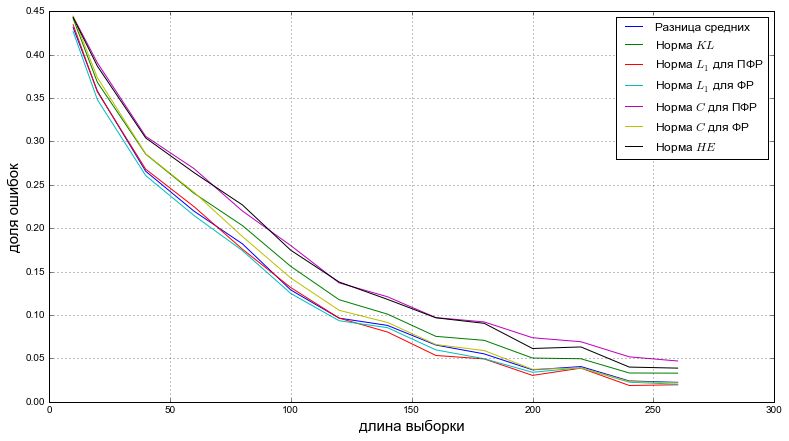

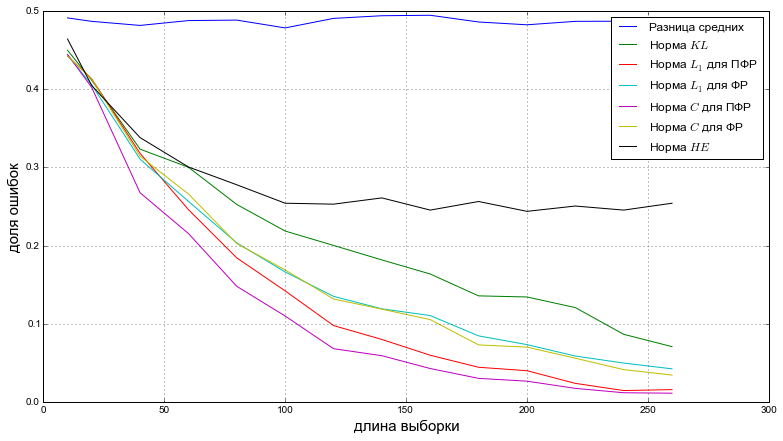

In [54]:
texts = (
    u"Пара гаусс-подобных распределений",
    u"Пара бимодальных распределений",
    u"Пара распределений с различными дисперсиями")
pairs = ((0, 1), (2, 3), (4, 5))
#Ns = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90]

for pair, text in zip(pairs, texts):
    figure(figsize=(13, 7))
    for method in methods:
        ys = [global_results[pair][N][method] for N in Ns[:-2]]
        plot(Ns[:-2], ys, label=convert_methods_names[method])

    #title(text, fontsize=18)
    ylabel(u'доля ошибок', fontsize=15)
    xlabel(u'длина выборки', fontsize=15)
    legend(loc=1)
    grid(True)
    savefig("/Users/alex/Documents/NIR/graph_fin_%s.png" % pair_to_short[(pair[0], pair[1])], 
            dpi=300)

In [175]:
# Реализация теоретической оценки ошибки для 
from math import erf, sqrt
from scipy.optimize import fmin_powell
def _F(z): return (1 + erf(z/sqrt(2))) / 2.0
def F(z, mu, s):
    return _F((z - mu)/s) 

def Error(e, mu1, mu2, s1, s2, N):
    k1 = sqrt(1.0/N)
    k = sqrt(2.0) * k1
    
    return 0.5 * (F(-e, 0, s1 * k) + F(-e, 0, s2 * k) + 
                  F(e, mu1-mu2, k1 * sqrt(s1*s1 + s2*s2)) -
                  F(-e, mu1-mu2, k1 * sqrt(s1*s1 + s2*s2) ))

def get_mean(pdf_num):
    return np.mean(xs * pdfs[pdf_num])

def get_sigma(pdf_num):
    return sqrt(np.mean((xs**2) * pdfs[pdf_num]) - get_mean(pdf_num)**2)

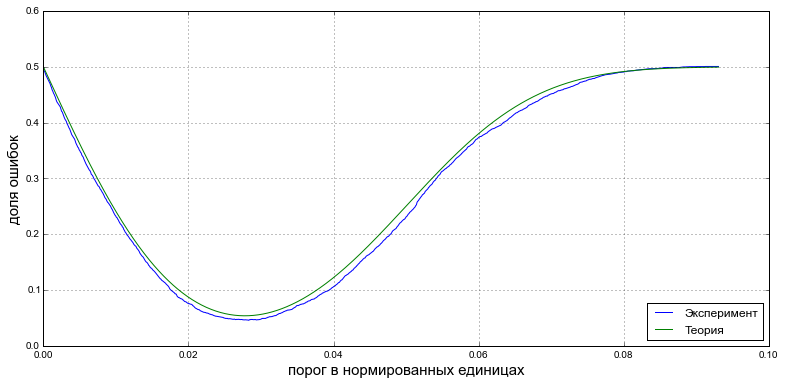

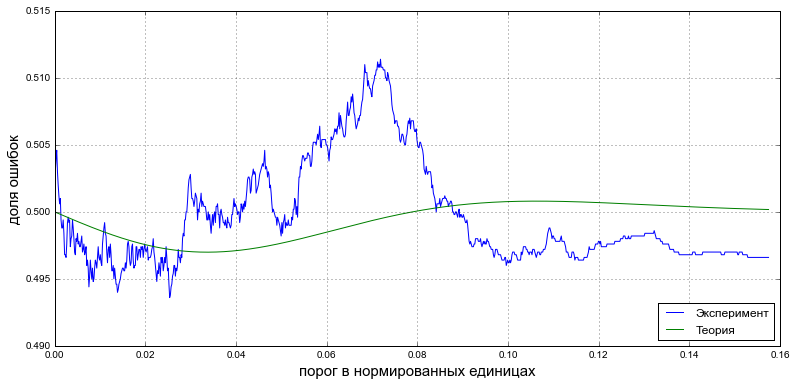

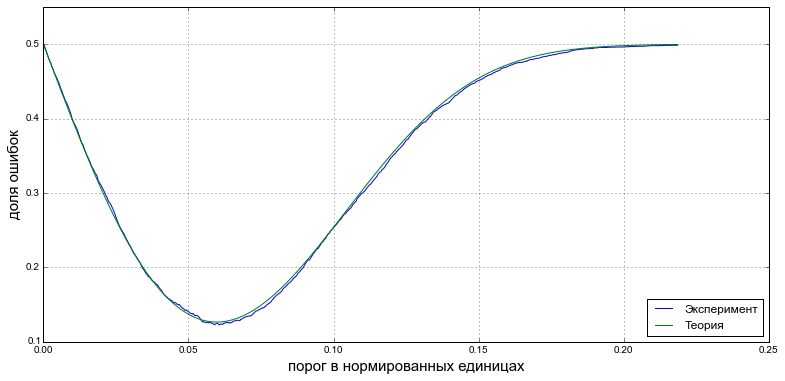

In [197]:
#Иллюстрация к сравнению T(e) с экспериментом (для нормы - модуль разницы средних)

N = 100
generateBaseNew(N) # Длина выборки = N
for key in pairs_dict:
    figure(figsize=(13,6))
    ind1, ind2 = key
    text = pairs_dict[key]

    # Расматриваем 5000 экспериментов
    # Анализируем пару (ind1, ind2) - первые два распределения.
    r = calc_dists_for_pair(ind1, ind2, 5000)
   

    g = r[methods[0]]
    _min = min(min(g[0]), min(g[1]))
    _max = max(max(g[0]), max(g[1]))
    steps = np.linspace(_min, _max, 1000)
    ys = np.asarray([calc_error(x, g) for x in steps])
    
    mu1, s1 = get_mean(ind1), get_sigma(ind1)
    mu2, s2 = get_mean(ind2), get_sigma(ind2)
    ys_theor = np.asarray([Error(x, mu1, mu2, s1, s2, N) for x in steps])
    plot(steps, ys, label=u"Эксперимент")
    plot(steps, ys_theor, label=u"Теория")
    #title(text % N, fontsize=18)
    ylabel(u'доля ошибок', fontsize=15)
    xlabel(u'порог в нормированных единицах', fontsize=15)
    legend(loc=4)
    grid(True)
    savefig("/Users/alex/Documents/NIR/exp_vs_theor_%s_N=%s.png" % (pair_to_short[(ind1, ind2)], N), dpi=300)

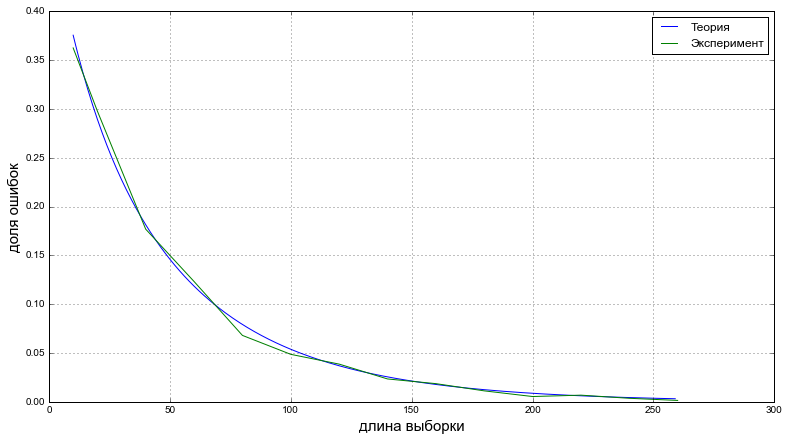

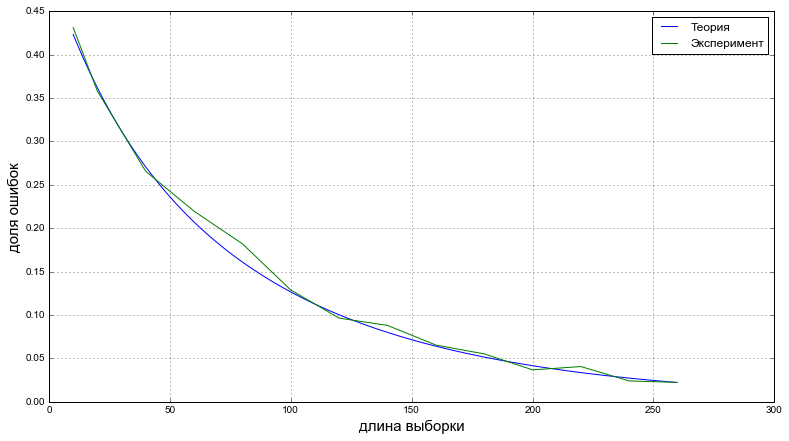

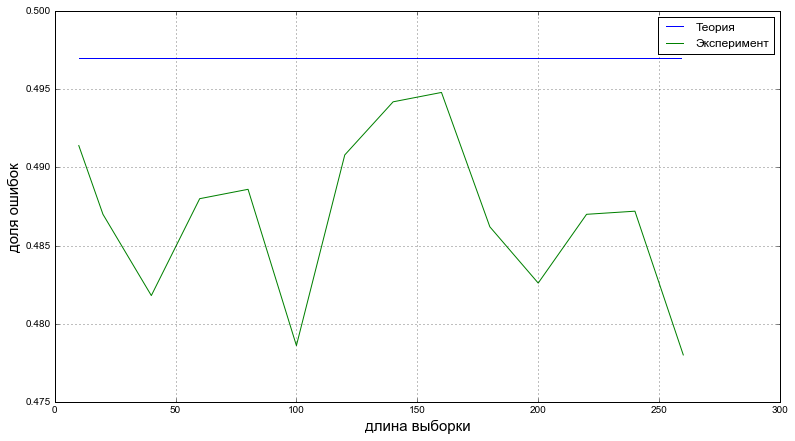

In [196]:
# Иллюстрация к сравнению графиков теоре
Ns = [10,  20,  40,  60,  80, 100,
          120, 140, 160, 180, 200,
          220, 240, 260, 280, 300]
for pair in pairs:
    figure(figsize=(13, 7))
    ind1, ind2 = pair
    mu1, s1 = get_mean(ind1), get_sigma(ind1)
    mu2, s2 = get_mean(ind2), get_sigma(ind2)
    def _temp_f(x):
        return Error(x, mu1, mu2, s1, s2, N)
    Ns_t = range(10,260)
    ys_t = [_temp_f(fmin_powell(_temp_f, 0.01)) for N in Ns_t]
    plot(Ns_t, ys_t, label=u"Теория")
    
    for method in methods[:1]:
        ys = [global_results[pair][N][method] for N in Ns[:-2]]
        plot(Ns[:-2], ys, label="Эксперимент")
    
    ylabel(u'доля ошибок', fontsize=15)
    xlabel(u'длина выборки', fontsize=15)
    legend(loc=1)
    grid(True)
    savefig("/Users/alex/Documents/NIR/fin_exp_vs_theor_%s.png" % pair_to_short[(pair[0], pair[1])], 
            wdpi=300)
        